In [1]:
from helpers.utilities import (
    DataFrame, Series, partial,
    T, F, pd
)
%run helpers/notebook_setup.ipynb

In [2]:
%R source('plots/colors.R');

In [3]:
from jupyter_helpers.selective_import import notebooks_importer

In [4]:
from analyses.integration.Uniform_preprocessing import (
    # data matrices
    raw_protein_matrix, raw_rna_matrix,
    clinical_union as clinical,
    # misc
    RNA_OUTLIERS,
    patients_union, patients_union_series, patients_with_both,
    # full response vectors derived from clinical data for
    # the union of patients with CSF RNA or with protein data
    protein_conditions,
    # preprocessing
    preprocess,

    # subsets of patients (uniform train-test split)
    full_cm_and_tmdr,        # CM+TMD+TMR patients with CSF RNA or protein data
    intersect_cm_and_tmdr,   # CM+TMD+TMR patients with both CSF RNA and protein data
    cm_and_tmdr_validation,  # CM+TMD+TMR patients with single omic data only
    tms_validation,          # CM patients with single omic data only + all TMS patients
)

Importing Jupyter notebook from /home/krassowski/meningitis-integration/analyses/integration/Uniform_preprocessing.ipynb


For diagnostics:

In [5]:
protein_full = preprocess('protein', 7, None).fit_transform(raw_protein_matrix.T)
rna_full = preprocess('rna', 7, None).fit_transform(raw_rna_matrix.T)

protein_full_groups = protein_full.index.map(clinical.Meningitis_with_tuberculosis_status)

[1] "Retaining: 99.92%"
[1] "Retaining: 52.62%"


In [6]:
CV_REPEATS = 100
MAX_COMPONENTS = 2

### Shared pipeline functions

In [7]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from machine_learning.multi_block_pipeline import TwoBlockPipeline
from machine_learning.data_classes import MultiBlockDataSet
from utilities import subset

from machine_learning.repeated_cv import (
    null_distributions_over_cv, cross_validate_and_test
)

Type 'citation("pROC")' for a citation.

Attaching package: ‘pROC’

The following objects are masked from ‘package:stats’:

    cov, smooth, var

Loading required package: ROCR
Loading required package: gplots

Attaching package: ‘gplots’

The following object is masked from ‘package:stats’:

    lowess

Loading required package: data.table
 
cvAUC version: 1.1.0
Notice to cvAUC users: Major speed improvements in version 1.1.0
 


Shared plotting functions:

In [8]:
from plots.cm_vs_tmdr_or_tms import cm_vs_tmdr_or_tms_roc_curves

%R import::here(roc_auc_tmdr_cm, .from='plots/cm_vs_tmdr_or_tms.R')

In [9]:
cross_validate = partial(
    cross_validate_and_test,
    response=clinical.Meningitis,
    case_class='Tuberculosis',
    use_seed=True,
    multi_scale=True,
    test_size_min=0.16,
    test_size_max=0.33,
    min_class_members=2
)

### OmicsPLS with custom Python wrapper

NIPALS is referred to as "alternative" or "power" method; to use it one should set `p_thresh=1` (so that it is lower than number of features in X) or do an analogous thing with q_thresh. I will use NIPALS as it is much faster implementation (7min vs 1s)

In [10]:
from machine_learning.utilities import format_grid_results
from helpers.o2pls import O2PLS, O2PLSStatistic
from helpers.o2pls import add_grid_metadata, summary_table_for
%R source('thirdparty/OmicsPLS_overrides.R');


Attaching package: ‘OmicsPLS’

The following object is masked from ‘package:stats’:

    loadings



Note: different rules for CV are used in SIMCA, as explained in "Multi- and Megavariate Data Analysis" Appendix II: Statistics, page 462 (Third revised edition). For predictive components threshold of Q2 > 0.01 is required (among other rules), for orthogonal components PCA rules apply.

A set of statistics will be computed during cross validation for every model:

In [11]:
cv_scoring = {
    name: statistic.calc
    for name, statistic in O2PLSStatistic.statistics.items()
}

In [12]:
%%R
import::here(
    grid_search_plot, grid_orthogonal_components_plot,
    .from='plots/omics_o2pls.R'
)

## Using protein scores extracted by O2PLS

In [13]:
class O2PLSSklearnAPI(O2PLS):

    def fit(self, X, y):
        return super().fit(X=X, Y=y)

    def transform(self, X, y):
        return super().transform(X=X, Y=y)

In [14]:
def create_o2pls_pipeline(smallest_group_n, outliers, predict, max_components=2, verbose=False, n_jobs=None):

    return TwoBlockPipeline(
        x=preprocess('rna', smallest_group_n, outliers),
        y=preprocess('protein', smallest_group_n, outliers),
        model=(
            GridSearchCV(
                O2PLSSklearnAPI(max_iterations=500, algorithm='nipals'),
                cv=3,  # repeated?
                iid=True,
                scoring={
                    'average_cv_predictions': cv_scoring['average_cv_predictions']
                },
                refit='average_cv_predictions',
                param_grid=[{
                    # remained: the second is non inclusive
                    'joint_components': range(1, max_components),
                    'x_ortho_components': range(0, max_components),
                    'y_ortho_components': range(0, max_components)
                }],
                verbose=verbose,
                n_jobs=n_jobs
            )
        ),
        predict=predict
    )


def predict_protein_scores(pipeline, dataset, calculate='calculate_Y_scores_U_without_osc'):
    prediction = pipeline.call(
        calculate,
        pipeline.y.transform(dataset.y)
    )
    if len(prediction.columns) != 1:  # for more columns, more advanced technique needed
        print('warning: more latent components chosen!', len(prediction.columns))
    return prediction[0]


o2pls_pipeline = create_o2pls_pipeline(
    smallest_group_n=7,
    outliers=RNA_OUTLIERS,
    verbose=0,
    max_components=MAX_COMPONENTS,
    predict=predict_protein_scores
)

[1] "Retaining: 52.62%"
[1] "Retaining: 99.92%"


In [15]:
def two_blocks_for_integration(rna, protein, patients, outliers, dummy_rna=False):
    b = subset(protein, patients, outliers=outliers)

    return {
        # for o2pls we only validate with protein data as we do not have enough paired observations
        'x': b if dummy_rna else subset(rna, patients, outliers=outliers).loc[b.index],
        'y': b
    }

In [16]:
tms_o2pls_protein_dataset = MultiBlockDataSet(
    two_blocks_for_integration(
        None, raw_protein_matrix,
        patients=tms_validation, outliers=RNA_OUTLIERS,
        dummy_rna=True
    ),
    case_class='Tuberculosis',
    response=clinical.Meningitis
)

OutliersFilter: filtering out 1 outliers


In [17]:
joint_o2pls = cross_validate(
    o2pls_pipeline,
    two_blocks_for_integration(
        raw_rna_matrix, raw_protein_matrix,
        patients=intersect_cm_and_tmdr, outliers=RNA_OUTLIERS
    ),
    test_data=two_blocks_for_integration(
        None, raw_protein_matrix,
        patients=cm_and_tmdr_validation, outliers=RNA_OUTLIERS,
        dummy_rna=True
    ),
    n=CV_REPEATS,
    verbose=F,
    stratify=T,
    coefficients={'x': 'W', 'y': 'C'},  # alternatives: _x_coefficients, _y_coefficients
    early_normalization=True
)

OutliersFilter: filtering out 0 outliers
OutliersFilter: filtering out 0 outliers
OutliersFilter: filtering out 3 outliers


/home/krassowski/meningitis-integration/machine_learning/repeated_cv.py:309: UserWarning: Using early normalization without leaky pipeline - is this intended?
  warn('Using early normalization without leaky pipeline - is this intended?')



Params chosen with CV vote: {'joint_components': 1, 'x_ortho_components': 0, 'y_ortho_components': 0}, based on voting: {(1, 0, 0): 93, (1, 1, 1): 7}  with average average_cv_predictions=-0.07857622495390035±0.025455927986357877, compared to -0.07718748416280787±0.0 of the next best choice ({'joint_components': 1, 'x_ortho_components': 1, 'y_ortho_components': 1}).


In [18]:
joint_o2pls.pipeline.model.calc_metrics()

,$R^2X$,$R^2Y$,$R^2X_{hat}$,$R^2Y_{hat}$,$R^2X_{YO}$,$R^2Y_{XO}$,$R^2X_{corr}$,$R^2Y_{corr}$
0,0.048197,0.160932,0.048197,0.160932,0.0,0.0,0.084166,0.281036


Warning: the values below are not $Q^2$, but $R^2$ (because they are computed on the training matrices)!

In [19]:
joint_o2pls.pipeline.model.calc_metrics(
    X=joint_o2pls.pipeline.transformed_blocks['x'],
    Y=joint_o2pls.pipeline.transformed_blocks['y']
)

,$Q^2X_{hat}$,$Q^2Y_{hat}$,$\frac{Q^2X_{hat} + Q^2Y_{hat}}{2}$
0,0.048197,0.160932,0.104565


In [20]:
roc_auc_o2pls = cm_vs_tmdr_or_tms_roc_curves(joint_o2pls, tms_o2pls_protein_dataset)

In [21]:
joint_o2pls.training_dataset.data['x'].head()

,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,...,AL357143.2,MIR7847,MIR6785,MIR4467,AC093390.2
149.TMD,0.0,2.0,17.0,54.99,19.01,...,0.0,0.0,0.0,0.0,0.0
001.TMD,1.0,0.0,0.0,11.00,4.00,...,0.0,0.0,0.0,0.0,1.0
151.TMD,7.0,0.0,43.0,107.18,20.82,...,0.0,0.0,0.0,0.0,0.0
170.TMD,12.0,5.0,36.0,113.13,71.87,...,0.0,0.0,0.0,0.0,4.0
083.TMD,4.0,0.0,46.0,485.06,32.94,...,0.0,0.0,0.0,0.0,0.0


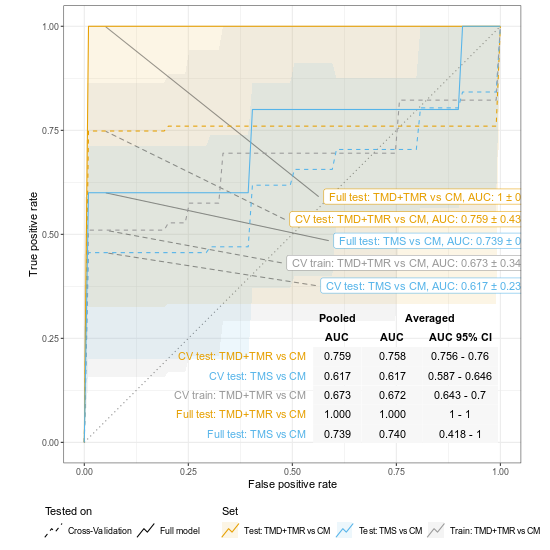

In [22]:
%%R -i roc_auc_o2pls -w 550 -h 550

# TODO: re-implenet with ggrepel?
roc_auc_tmdr_cm(roc_auc_o2pls, annotation=0.05)

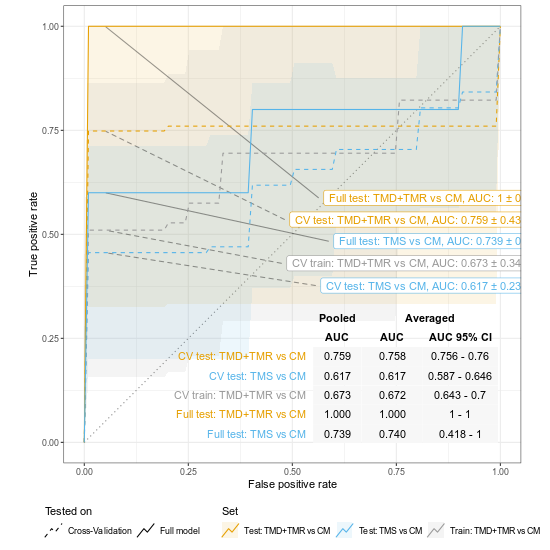

In [23]:
%%R -i roc_auc_o2pls -w 550 -h 550

roc_auc_tmdr_cm(roc_auc_o2pls, annotation=0.05)

In [24]:
len(joint_o2pls.cross_validation.splits)

100

In [25]:
first_split = joint_o2pls.cross_validation.splits[0]
first_split.keys()

dict_keys(['test_ratio', 'train_ratio', 'pipeline'])

This is just for one of the split ratios:

In [26]:
first_split['test_ratio'], first_split['train_ratio']

(0.24, 0.76)

In [27]:
grid_results = add_grid_metadata(format_grid_results(
    first_split['pipeline'].model,
    first_split['pipeline'].transformed_blocks['x']
))

In [28]:
grid_results.head()

,param_joint_components,param_x_ortho_components,param_y_ortho_components,variable,value,...,symbol,joint_mean,mean,std,ortho_gain_percent
0,1.0,0.0,0.0,split0_test_average_cv_predictions,-0.040616,...,$\frac{Q^2X_{hat} + Q^2Y_{hat}}{2}$,-0.073505,-0.053369,0.049326,27.394325
1,1.0,0.0,1.0,split0_test_average_cv_predictions,-0.090353,...,$\frac{Q^2X_{hat} + Q^2Y_{hat}}{2}$,-0.073505,-0.101367,0.048210,-37.904275
2,1.0,1.0,0.0,split0_test_average_cv_predictions,-0.063782,...,$\frac{Q^2X_{hat} + Q^2Y_{hat}}{2}$,-0.073505,-0.068163,0.037268,7.267971
3,1.0,1.0,1.0,split0_test_average_cv_predictions,-0.056393,...,$\frac{Q^2X_{hat} + Q^2Y_{hat}}{2}$,-0.073505,-0.071122,0.060566,3.241978
4,1.0,0.0,0.0,split1_test_average_cv_predictions,-0.011671,...,$\frac{Q^2X_{hat} + Q^2Y_{hat}}{2}$,-0.073505,-0.053369,0.049326,27.394325


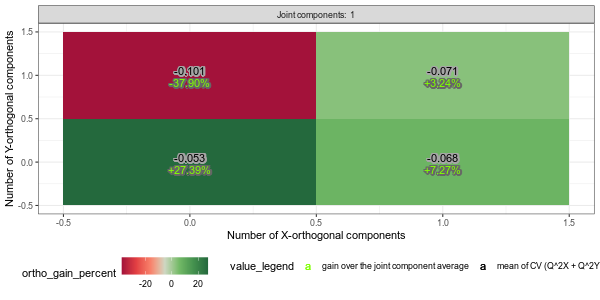

In [29]:
%%R -w 600 -h 300 -i grid_results
grid_orthogonal_components_plot(grid_results)

#### Features driving models with high AUC

In [30]:
joint_o2pls.cross_validation.contributions.x.add_weighted_auc(
    joint_o2pls.sub_sampling_test_results.cv_auc
)
joint_o2pls.cross_validation.contributions.y.add_weighted_auc(
    joint_o2pls.sub_sampling_test_results.cv_auc
)

In [31]:
joint_o2pls_contribs_rna = joint_o2pls.cross_validation.contributions.x.data
joint_o2pls_contribs_protein = joint_o2pls.cross_validation.contributions.y.data

In [32]:
joint_o2pls.cross_validation.contributions.x.add_above_abs_quantile(q=0.5)
joint_o2pls.cross_validation.contributions.y.add_above_abs_quantile(q=0.5)

In [33]:
joint_o2pls.cross_validation.contributions.x.add_above_abs_quantile(q=0.9)
joint_o2pls.cross_validation.contributions.y.add_above_abs_quantile(q=0.9)

In [34]:
%%R
import::here(
    plots_most_frequently_included, plot_most_significant, plot_highest_magnitutude,
    coefficients_volcano_plot, mean_vs_coefficients,
    .from='plots/coefficients.R'
)

In [35]:
joint_o2pls.cross_validation.contributions.x.add_above_abs_quantile(q=0.95)
joint_o2pls.cross_validation.contributions.y.add_above_abs_quantile(q=0.95)

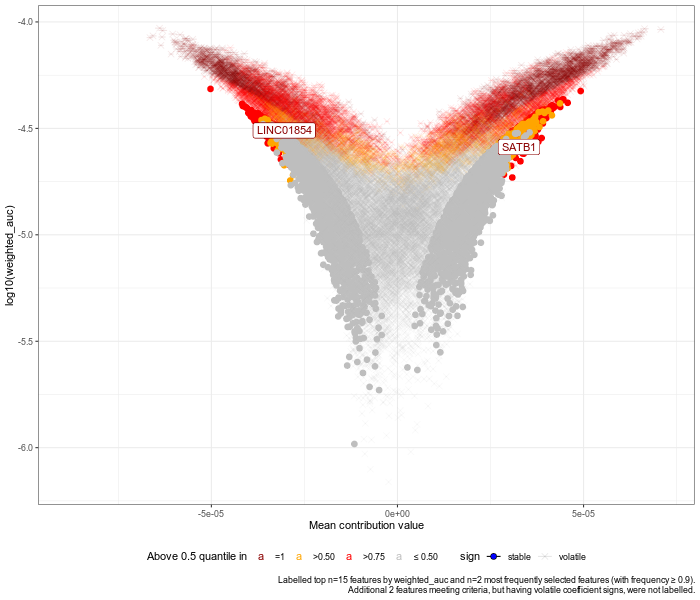

In [122]:
%%R -w 700 -h 600 -i joint_o2pls_contribs_rna
coefficients_volcano_plot(
    joint_o2pls_contribs_rna,
    n=15, p_value='weighted_auc', neg=F,
    quite_stable_alpha=0.3, volatile_alpha=0.1,
    highlight_frequent=0.9, frequency='above_abs_iteration_quantile_0.5',
    frequency_title='Above 0.5 quantile in',
    highlight_top=TRUE
) + ylab('Mean contribution value')

Stable: is stable in over 99% of iterations
Almost stable: is stable in over 90% of iterations (previously termed as "unstable")
Volatile: is stable in less than 90% of iterations.

Highlight: genes with volatile sign were excluded;

top $n$ non-volatile genes with high proportion of contributions to the most successful models were highlighted in the bright red; additionally the genes consistently selected (with value of contribution above median in all iterations) were highlighted in dark red colour (which overrides the bright red if a gene is both in the top and in the most frequently selected subset).

Ideally for comparison with lasso we would say that the protein is selected if it was in top n proteins where n is the average number of coefficients selected by LASSO

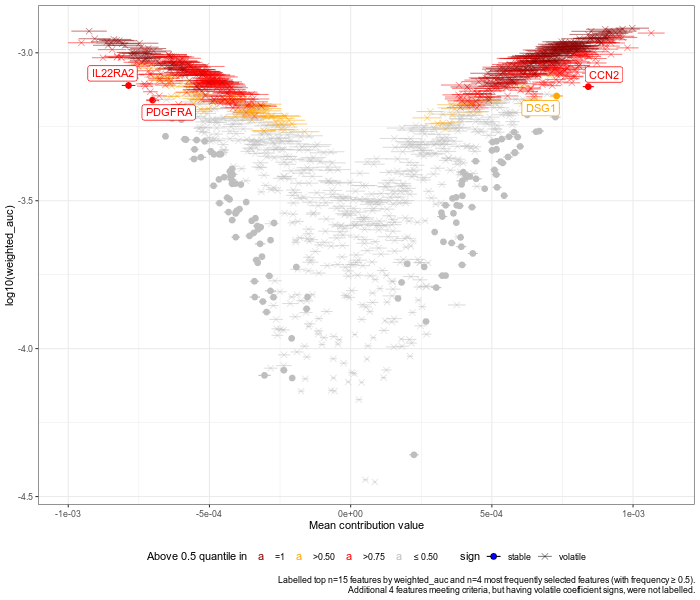

In [123]:
%%R -w 700 -h 600  -i joint_o2pls_contribs_protein

g = coefficients_volcano_plot(
    joint_o2pls_contribs_protein,
    n=15, p_value='weighted_auc', neg=F,
    quite_stable_alpha=0.75, volatile_alpha=0.5,
    highlight_frequent=0.5, frequency='above_abs_iteration_quantile_0.5',
    frequency_title='Above 0.5 quantile in',
    highlight_top=TRUE
) + ylab('Mean contribution value')

g

In [39]:
protein_full.T.loc['GPC2'].groupby(protein_full_groups).mean()

Cryptococcal            -0.415220
Definite tuberculosis   -0.810611
Healthy control          0.852763
Possible tuberculosis   -0.055144
Probable tuberculosis   -0.405677
Viral                    0.336394
Name: GPC2, dtype: float64

In [40]:
joint_o2pls.cross_validation.contributions.y.add_hdi_significance(
    joint_o2pls.training_dataset.y,
    joint_o2pls.training_dataset.binary_response,
    family='gaussian'
)

Loading required package: scalreg
Loading required package: lars
Loaded lars 1.2

Nodewise regressions will be computed as no argument Z was provided.
You can store Z to avoid the majority of the computation next time around.
Z only depends on the design matrix x.


In [41]:
joint_o2pls_contribs_protein.sort_values('above_abs_iteration_quantile_0.9')

,mean,selected_in,positive_in,negative_in,volatile,...,above_abs_iteration_quantile_0.5,above_abs_iteration_quantile_0.9,above_abs_iteration_quantile_0.95,gaussian_p,gaussian_FDR
STUB1,0.000259,1.0,0.69,0.31,0.62,...,0.48,0.00,0.00,0.518065,0.956014
CEBPB,0.000808,1.0,0.76,0.24,0.48,...,0.76,0.00,0.00,0.393804,0.956014
ENO2,-0.000486,1.0,0.24,0.76,0.48,...,0.52,0.00,0.00,0.399672,0.956014
PIAS4,0.000652,1.0,0.76,0.24,0.48,...,0.52,0.00,0.00,0.448672,0.956014
IL10RA,-0.000587,1.0,0.24,0.76,0.48,...,1.00,0.00,0.00,0.953482,0.989579
...,...,...,...,...,...,...,...,...,...,...,...
STIP1,0.000720,1.0,0.76,0.24,0.48,...,1.00,0.93,0.26,0.272559,0.956014
HINT1,0.000662,1.0,0.76,0.24,0.48,...,1.00,0.93,0.00,0.852331,0.964759
HSPA8,0.000851,1.0,0.76,0.24,0.48,...,1.00,0.93,0.69,0.276768,0.956014
UBE2G2,0.000652,1.0,0.76,0.24,0.48,...,0.93,0.93,0.00,0.763897,0.956014


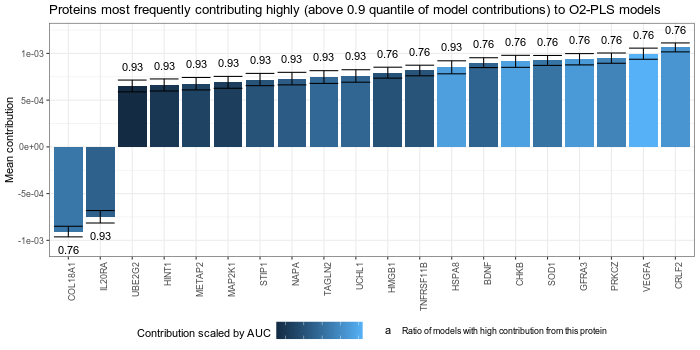

In [42]:
%%R -i joint_o2pls_contribs_protein -w 700 -h 350
(
    plots_most_frequently_included(
        joint_o2pls_contribs_protein, n=20, label_margin=0.0001,
        frequency='above_abs_iteration_quantile_0.9',
        fill='weighted_auc',
        fill_name='Contribution scaled by AUC',
        #label='gaussian_p',
        label_name='Ratio of models with high contribution from this protein', type='contribution'
    )
    + xlab('Protein')
    + ggtitle(
        'Proteins most frequently contributing highly (above 0.9 quantile of model contributions) to O2-PLS models'
    )
    + guides(
        fill=guide_colourbar(label=FALSE, order=1)
    )
    + theme(
        legend.margin=margin(b=0, unit='cm'),
        axis.title.x=element_blank()
    )
)

Compare with the list of https://www.hindawi.com/journals/mi/2019/7582948/:
 - IFN-γ, MIP-4, CXCL9, CCL1, RANTES, IL-6, TNF-α, MPO, MMP-9, MMP-8, CC2, IL-10, PAI-1, CXCL8, IL-1b, A1AT, CXCL10, G-CSF, CC4, CC4b, GM-CSF, PDGF AB/BB, Apo-AI, MBL, ferritin, CC5a, SAP, and CC5

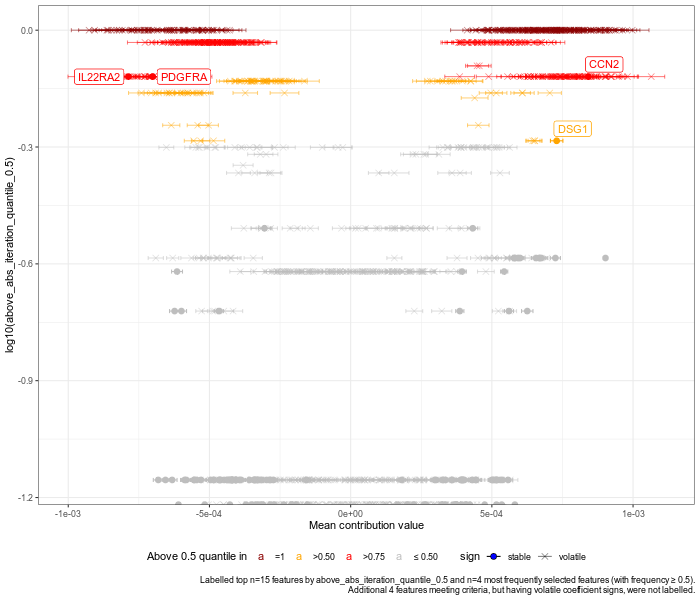

In [125]:
%%R -w 700 -h 600  -i joint_o2pls_contribs_protein

coefficients_volcano_plot(
    joint_o2pls_contribs_protein,
    n=15, p_value='above_abs_iteration_quantile_0.5', neg=F,
    quite_stable_alpha=0.75, volatile_alpha=0.5,
    highlight_frequent=0.5, frequency='above_abs_iteration_quantile_0.5',
    frequency_title='Above 0.5 quantile in',
    highlight_top=TRUE
) + ylab('Mean contribution value')

## Enrichment

In [57]:
import analyses.integration.Pathway_enrichment
%R import::here(camera_pr, .from='helpers/pathways.R')

General picture of meningitis, not related to disease etiology and indifferent to the method in use, as discoverable when using observed subset of transcripts/proteins:

In [58]:
%R camera_pr(joint_o2pls_contribs_protein, 'mean_abundance', hallmarks_for_protein)

[1] "Removed 2 NAs"


,NGenes,Direction,PValue,FDR
OXIDATIVE PHOSPHORYLATION,9.0,Down,0.000010,0.000477
UNFOLDED PROTEIN RESPONSE,8.0,Up,0.045211,0.999055
ESTROGEN RESPONSE LATE,31.0,Down,0.114043,0.999055
HYPOXIA,46.0,Up,0.161131,0.999055
INTERFERON ALPHA RESPONSE,13.0,Down,0.168909,0.999055
...,...,...,...,...
UV RESPONSE UP,26.0,Up,0.938355,0.999055
TGF BETA SIGNALING,11.0,Down,0.960442,0.999055
INTERFERON GAMMA RESPONSE,47.0,Up,0.984216,0.999055
TNFA SIGNALING VIA NFKB,54.0,Down,0.991590,0.999055


In [59]:
%R camera_pr(joint_o2pls_contribs_rna, 'mean_abundance', hallmarks_for_rna)

[1] "Removed 406 NAs"


,NGenes,Direction,PValue,FDR
ANDROGEN RESPONSE,97.0,Up,0.000543,0.027127
DNA REPAIR,150.0,Up,0.008871,0.221781
HEME METABOLISM,182.0,Up,0.020679,0.344655
PI3K AKT MTOR SIGNALING,100.0,Up,0.047231,0.590383
PROTEIN SECRETION,95.0,Up,0.083887,0.764755
...,...,...,...,...
UV RESPONSE DN,143.0,Up,0.898260,0.936601
ESTROGEN RESPONSE LATE,191.0,Up,0.903209,0.936601
HYPOXIA,194.0,Down,0.904525,0.936601
APOPTOSIS,159.0,Down,0.917869,0.936601


Naive group differences (should not be taken too seriously, the difference metric is known to be weak), supervised:

In [47]:
def get_diff(data, group_a, group_b, func=lambda a, b: a - b):
    a = data[data.index.str.contains(group_a)].mean()
    b = data[data.index.str.contains(group_b)].mean()
    return func(a, b).to_frame('diff')

In [48]:
protein_diff = get_diff(protein_full, 'TMD|TMR', 'CM')
rna_diff = get_diff(rna_full, 'TMD|TMR', 'CM')
protein_diff.head()

,diff
STUB1,0.629198
CEBPB,0.596851
ENO2,-0.478050
PIAS4,0.433054
IL10RA,-0.731442


In [49]:
%R -i protein_diff -i rna_diff

In [80]:
%%R
library(RColorBrewer)
brewer.pal(5, 'Dark2')

[1] "#1B9E77" "#D95F02" "#7570B3" "#E7298A" "#66A61E"


### Hallmarks comparison

In [146]:
%%R
top_n = 10
# these are based on the abundance difference
protein = head(camera_pr(protein_diff, 'diff', hallmarks_for_protein), top_n)
RNA = head(camera_pr(rna_diff, 'diff', hallmarks_for_rna), top_n)

rna_label = 'RNA (abundance difference)'
protein_label = 'Protein (abundance difference)'

# these are based on the protein/RNA contributions
o2pls_protein_label = 'Mean of contributions O2-PLS (proteins)'
o2pls_rna_label = 'Mean of contributions O2-PLS (RNA)'

RNA$gene = rownames(RNA)
RNA$kind = rna_label
RNA$from = rna_label

protein$gene = rownames(protein)
protein$kind = protein_label
protein$from = protein_label


contributions_pathways = function(o2pls, label, RNA, protein) {
    o2pls$gene = rownames(o2pls)
    o2pls$kind = label
    o2pls$from = ifelse(
        rownames(o2pls) %in% rownames(RNA) & rownames(o2pls) %in% rownames(protein),
        'Both',
        ifelse(
            rownames(o2pls) %in% rownames(RNA),
            rna_label,
            ifelse(rownames(o2pls) %in% rownames(protein), protein_label, 'Neither')
        )
    )
    o2pls
}


o2pls_protein = contributions_pathways(
    head(camera_pr(joint_o2pls_contribs_protein, 'mean', hallmarks_for_protein), top_n),
    label=o2pls_protein_label,
    RNA, protein
)

o2pls_rna = contributions_pathways(
    head(camera_pr(joint_o2pls_contribs_rna, 'mean', hallmarks_for_rna), top_n),
    label=o2pls_rna_label,
    RNA, protein
)

In [147]:
%%R
pathway_colors = c('#D95F02', '#E7298A', '#7570B3', '#1B9E77')
names(pathway_colors) = c('Both', 'Neither', protein_label, rna_label)

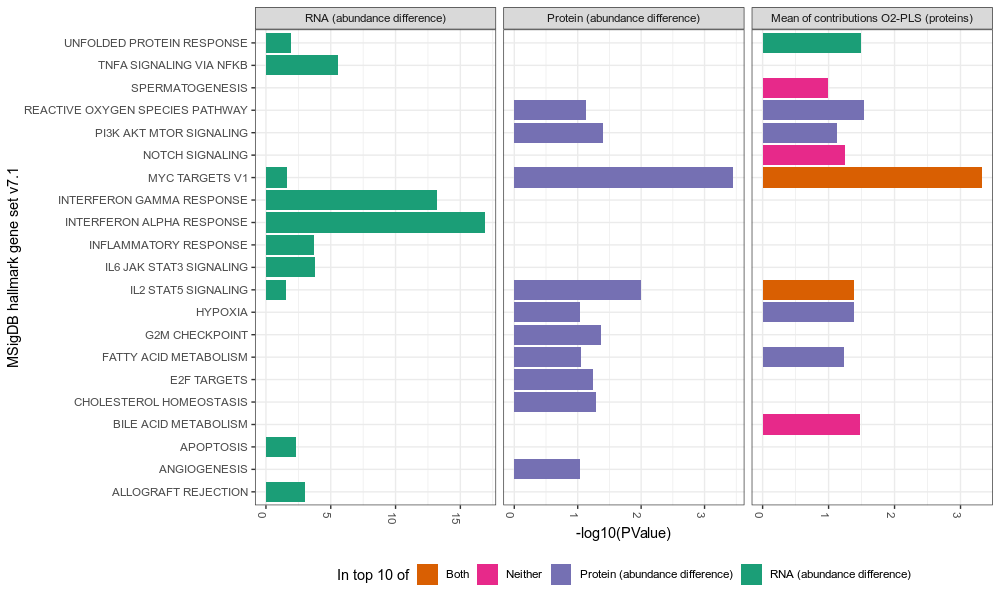

In [148]:
%%R -w 1000 -r 95 -h 600
df = rbind(protein, RNA, o2pls_protein)
df$kind = factor(df$kind, levels=c(rna_label, protein_label, o2pls_protein_label))

(
    ggplot(df, aes(x=gene, y=-log10(PValue), fill=from))
    + geom_bar(stat='identity')
    + facet_wrap('kind', scale='free_x')
    + nice_theme
    + theme(axis.text.x=element_text(angle = -90, hjust = 0))
    + coord_flip()
    + scale_fill_manual(name='In top 10 of', values=pathway_colors)
    + xlab('MSigDB hallmark gene set v7.1')
)

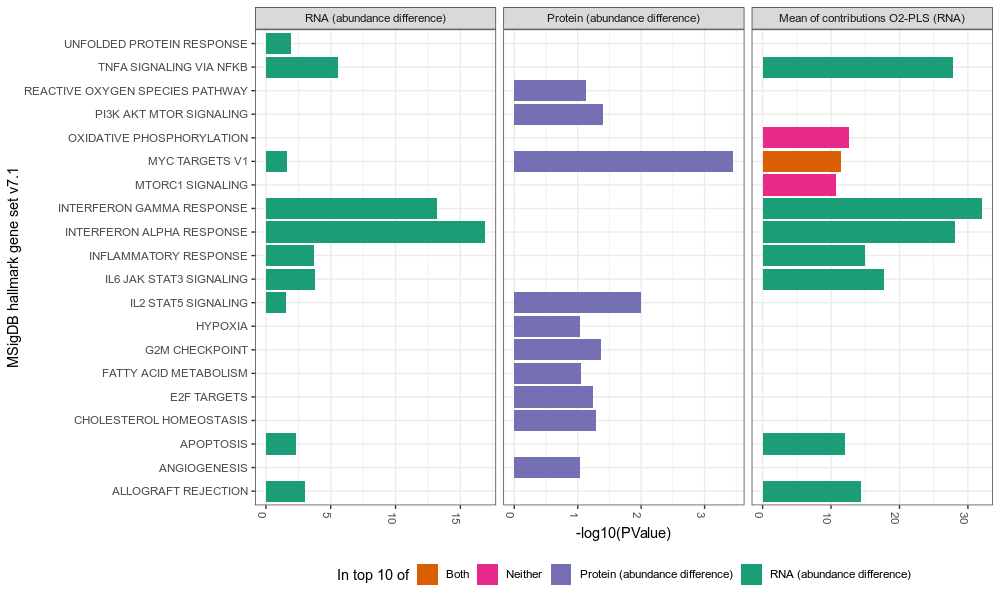

In [149]:
%%R -w 1000 -r 95 -h 600
df = rbind(protein, RNA, o2pls_rna)
df$kind = factor(df$kind, levels=c(rna_label, protein_label, o2pls_rna_label))

(
    ggplot(df, aes(x=gene, y=-log10(PValue), fill=from))
    + geom_bar(stat='identity')
    + facet_wrap('kind', scale='free_x')
    + nice_theme
    + theme(axis.text.x=element_text(angle = -90, hjust = 0))
    + coord_flip()
    + scale_fill_manual(name='In top 10 of', values=pathway_colors)
    + xlab('MSigDB hallmark gene set v7.1')
)

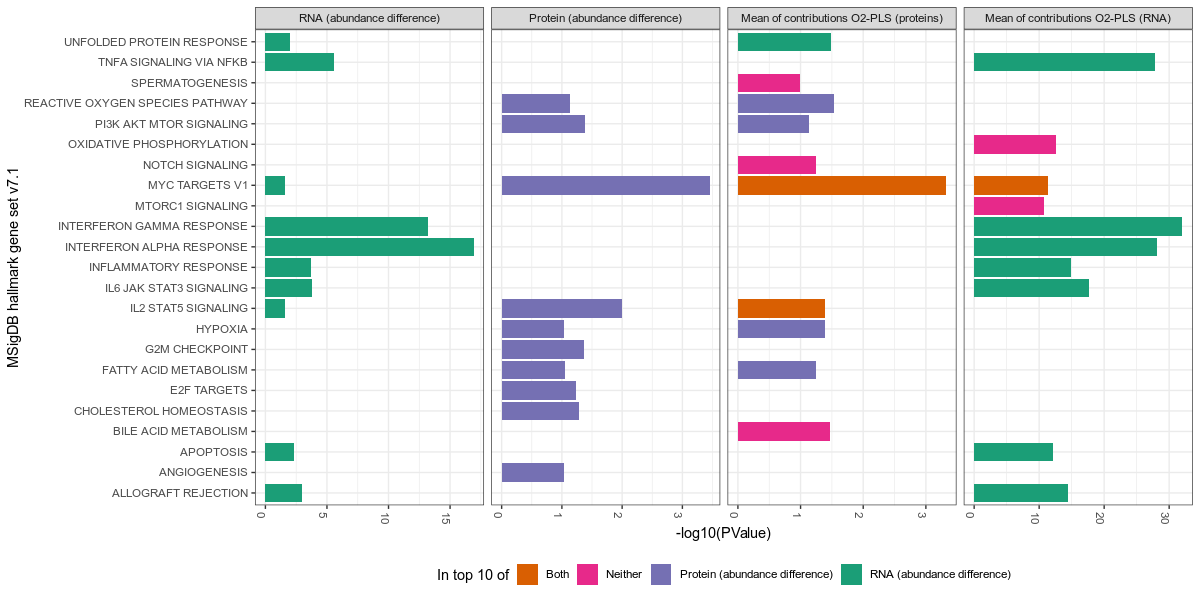

In [150]:
%%R -w 1200 -r 95 -h 600
df = rbind(protein, RNA, o2pls_protein, o2pls_rna)
df$kind = factor(df$kind, levels=c(rna_label, protein_label, o2pls_protein_label, o2pls_rna_label))

(
    ggplot(df, aes(x=gene, y=-log10(PValue), fill=from))
    + geom_bar(stat='identity')
    + facet_wrap('kind', scale='free_x', ncol=4)
    + nice_theme
    + theme(axis.text.x=element_text(angle = -90, hjust = 0))
    + coord_flip()
    + scale_fill_manual(name='In top 10 of', values=pathway_colors)
    + xlab('MSigDB hallmark gene set v7.1')
)

### Reactome comparison

In [151]:
%%R
top_n = 15
# these are based on the abundance difference
protein = head(camera_pr(protein_diff, 'diff', reactome_for_protein), top_n)
RNA = head(camera_pr(rna_diff, 'diff', reactome_for_rna), top_n)

rna_label = 'RNA (abundance difference)'
protein_label = 'Protein (abundance difference)'

# these are based on the protein/RNA contributions
o2pls_protein_label = 'Mean of contributions O2-PLS (proteins)'
o2pls_rna_label = 'Mean of contributions O2-PLS (RNA)'

RNA$gene = rownames(RNA)
RNA$kind = rna_label
RNA$from = rna_label

protein$gene = rownames(protein)
protein$kind = protein_label
protein$from = protein_label


contributions_pathways = function(o2pls, label, RNA, protein) {
    o2pls$gene = rownames(o2pls)
    o2pls$kind = label
    o2pls$from = ifelse(
        rownames(o2pls) %in% rownames(RNA) & rownames(o2pls) %in% rownames(protein),
        'Both',
        ifelse(
            rownames(o2pls) %in% rownames(RNA),
            rna_label,
            ifelse(rownames(o2pls) %in% rownames(protein), protein_label, 'Neither')
        )
    )
    o2pls
}


o2pls_protein = contributions_pathways(
    head(camera_pr(joint_o2pls_contribs_protein, 'mean', reactome_for_protein), top_n),
    label=o2pls_protein_label,
    RNA, protein
)

o2pls_rna = contributions_pathways(
    head(camera_pr(joint_o2pls_contribs_rna, 'mean', reactome_for_rna), top_n),
    label=o2pls_rna_label,
    RNA, protein
)

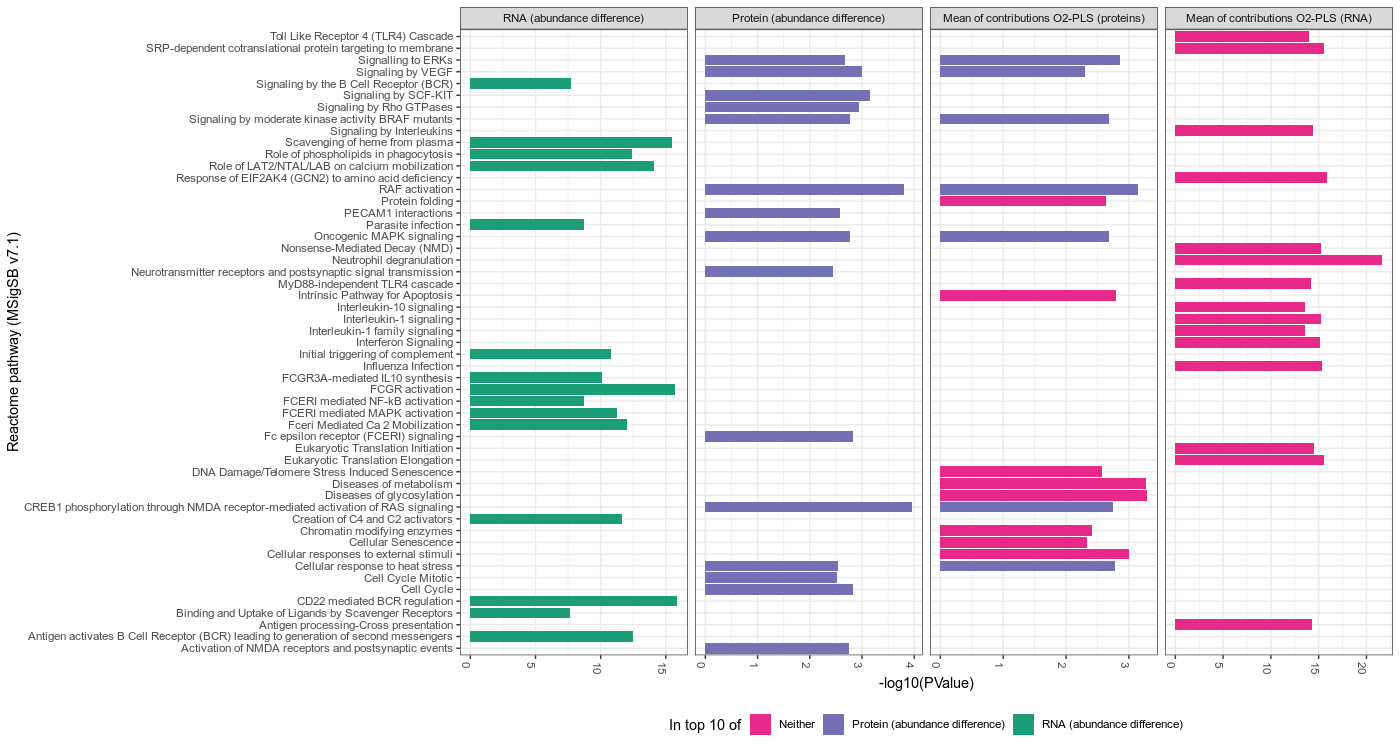

In [153]:
%%R -w 1400 -r 95 -h 750
df = rbind(protein, RNA, o2pls_protein, o2pls_rna)
df$kind = factor(df$kind, levels=c(rna_label, protein_label, o2pls_protein_label, o2pls_rna_label))

(
    ggplot(df, aes(x=gene, y=-log10(PValue), fill=from))
    + geom_bar(stat='identity')
    + facet_wrap('kind', scale='free_x', ncol=4)
    + nice_theme
    + theme(axis.text.x=element_text(angle = -90, hjust = 0))
    + coord_flip()
    + scale_fill_manual(name='In top 10 of', values=pathway_colors)
    + xlab('Reactome pathway (MSigSB v7.1)')
)

In [117]:
%R head(camera_pr(joint_o2pls_contribs_protein, 'mean', reactome_for_protein), 10)

,NGenes,Direction,PValue,FDR
Diseases of glycosylation,27.0,Down,0.000507,0.122349
Diseases of metabolism,38.0,Down,0.000540,0.122349
RAF activation,9.0,Up,0.000720,0.122349
Cellular responses to external stimuli,70.0,Up,0.000998,0.122349
Signalling to ERKs,18.0,Up,0.001405,0.122349
Intrinsic Pathway for Apoptosis,23.0,Up,0.001616,0.122349
Cellular response to heat stress,14.0,Up,0.001662,0.122349
CREB1 phosphorylation through NMDA receptor-mediated activation of RAS signaling,8.0,Up,0.001795,0.122349
Signaling by moderate kinase activity BRAF mutants,16.0,Up,0.002106,0.122349
Oncogenic MAPK signaling,16.0,Up,0.002106,0.122349


In [118]:
%R head(camera_pr(joint_o2pls_contribs_protein, 'weighted_auc', reactome_for_protein), 10)

[1] "Removed 4 NAs"


,NGenes,Direction,PValue,FDR
Signaling by NTRKs,33.0,Up,0.000243,0.140979
Pre-NOTCH Expression and Processing,8.0,Up,0.001735,0.332697
Cellular responses to external stimuli,70.0,Up,0.002794,0.332697
Nuclear Events (kinase and transcription factor activation),9.0,Up,0.003749,0.332697
Cellular response to heat stress,14.0,Up,0.004122,0.332697
TNFs bind their physiological receptors,25.0,Down,0.004546,0.332697
Signalling to ERKs,18.0,Up,0.004574,0.332697
RAF-independent MAPK1/3 activation,11.0,Up,0.004947,0.332697
MAPK1 (ERK2) activation,8.0,Up,0.006159,0.332697
L1CAM interactions,26.0,Up,0.006501,0.332697


#### RNA

In [119]:
%R head(camera_pr(joint_o2pls_contribs_rna, 'mean', reactome_for_rna), 10)

,NGenes,Direction,PValue,FDR
Neutrophil degranulation,458.0,Up,2.133856e-22,3.051414e-19
Response of EIF2AK4 (GCN2) to amino acid deficiency,101.0,Up,1.425676e-16,1.019358e-13
Eukaryotic Translation Elongation,92.0,Up,2.708005e-16,1.080256e-13
SRP-dependent cotranslational protein targeting to membrane,112.0,Up,3.021695e-16,1.080256e-13
Influenza Infection,153.0,Up,4.634890e-16,1.237520e-13
Interleukin-1 signaling,99.0,Up,5.578249e-16,1.237520e-13
Nonsense-Mediated Decay (NMD),115.0,Up,6.057792e-16,1.237520e-13
Interferon Signaling,196.0,Up,7.089548e-16,1.267257e-13
Eukaryotic Translation Initiation,119.0,Up,3.378056e-15,5.367355e-13
Signaling by Interleukins,425.0,Up,4.201167e-15,6.007669e-13


In [120]:
%R head(camera_pr(joint_o2pls_contribs_rna, 'weighted_auc', reactome_for_rna), 10)

[1] "Removed 534 NAs"


,NGenes,Direction,PValue,FDR
Interleukin-10 signaling,44.0,Up,2.662969e-10,3.808046e-07
Neutrophil degranulation,458.0,Up,8.242382e-08,5.893303e-05
Diseases of Immune System,23.0,Up,3.149453e-07,1.501239e-04
p75NTR signals via NF-kB,16.0,Up,4.383541e-06,1.488925e-03
Interleukin-1 processing,8.0,Up,5.206031e-06,1.488925e-03
Interleukin-4 and Interleukin-13 signaling,103.0,Up,1.096353e-05,2.612975e-03
Purinergic signaling in leishmaniasis infection,24.0,Up,2.764938e-05,5.648373e-03
Biosynthesis of EPA-derived SPMs,6.0,Up,4.035920e-05,6.910302e-03
CD163 mediating an anti-inflammatory response,9.0,Up,4.349141e-05,6.910302e-03
Activation of TRKA receptors,6.0,Up,5.209780e-05,7.449985e-03


## Scratchpad and ideas for future research

- Pathways enrichment might be more meaningful with Ridge regularization
- Random forest would be another very simple but potentially useful classifier
- Group LASSO may solve the issue of multi-collinearity, there is an sklearn-API for it: https://pypi.org/project/group-lasso/